# Analysis and prediction of Covid-19 data using Python

In [1]:
import seaborn 
from matplotlib import pyplot as pyplot
import requests
import json
import pandas
import numpy

import tensorflow
from tensorflow import keras


## 1. Récupération de bases de données

Récuperer les données covid en temps réel au format JSON grâce au site "Our world in data" qui met à disposition toutes ces données. 
Voici un projet Github expliquant comment utiliser l'intégralité des données Covid mises à disposistion : https://github.com/owid/covid-19-data/tree/master/public/data

In [2]:
url = "https://covid.ourworldindata.org/data/owid-covid-data.json"
resp = requests.get(url)
print(f"Response status code : {resp.status_code}")

Response status code : 200


Une fois les données récupérées : status_code = 200, nous pouvons les parcourir. 
Le fichier renvoyé est au format JSON.

En fonction des jours et des pays, les données récoltées ne sont pas les mêmes, voyons donc quelles sont les différentes données mises à disposition pour la suisse 
Le code ISO pour la suisse est CHE.

In [3]:
json_input = json.loads(resp.content)

iso = "CHE"
for key, value in json_input[iso].items(): 
	if key != "data":
		print(f"{key} : {value}")

continent : Europe
location : Switzerland
population : 8715494.0
population_density : 214.243
median_age : 43.1
aged_65_older : 18.436
aged_70_older : 12.644
gdp_per_capita : 57410.166
cardiovasc_death_rate : 99.739
diabetes_prevalence : 5.59
female_smokers : 22.6
male_smokers : 28.9
hospital_beds_per_thousand : 4.53
life_expectancy : 83.78
human_development_index : 0.955


In [4]:
pandas.set_option('display.max_row', 200)
pandas.set_option('display.max_column', 200)

data = json_input[iso]['data']
df = pandas.DataFrame(data)
df['date'] = pandas.to_datetime(df['date'])
df = df.set_index('date')
print(df.columns)

print(f"\nData gathered on {len(df)} days, from {df.index[0]} to {df.index[len(df) - 1]}.")

Index(['total_cases', 'new_cases', 'total_cases_per_million',
       'new_cases_per_million', 'stringency_index', 'new_cases_smoothed',
       'new_deaths_smoothed', 'new_cases_smoothed_per_million',
       'new_deaths_smoothed_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million',
       'excess_mortality_cumulative_absolute', 'excess_mortality_cumulative',
       'excess_mortality', 'excess_mortality_cumulative_per_million',
       'total_deaths', 'new_deaths', 'total_deaths_per_million',
       'new_deaths_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand', 'positive_rate',
       'tests_per_case', 'tests_units', 'new_tests_smoothed',
       'new_tests_smoothed_per_thousand', 'total_vaccinations',
       'people_vaccinated', 'total_vaccinations_per_hundred',
       'people_vaccina

Voici ci-dessus toutes les informations disponibles pour la Suisse.

Voyons ce que donne un graphique sur l'évolution du nombre de nouveaux cas covid chaque jour depuis le début de la pandémie.

## 2. Représentation des données

In [5]:
# Analyse de forme

print(f"Shape: {df.shape}")
print(f"Data types: \n{df.dtypes.value_counts()}")

Shape: (601, 42)
Data types: 
float64    41
object      1
dtype: int64


<AxesSubplot:ylabel='date'>

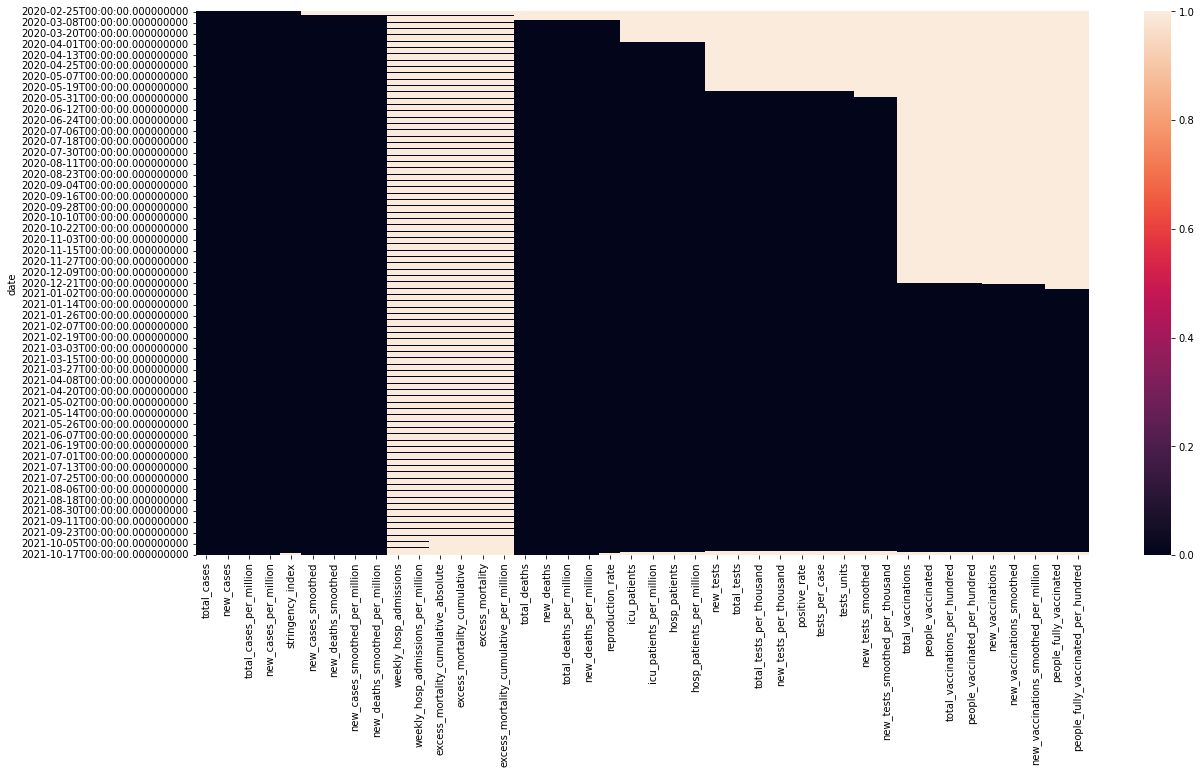

In [6]:
# Analyse des NaN

pyplot.figure(figsize=(20,10))
seaborn.heatmap(df.isna())

# Les NaN sont en beige sur le graphe, il y en a beaucoup, mais on va pouvoir les virer par la suite
# Les lignes (lorsqu'il y a du beige) sont surement liés  

In [7]:
# On trie les différentes données pour voir lesquelles possèdent le plus de NaN
(df.isna().sum() / df.shape[0]).sort_values(ascending=False)

# Pas mal de Nan, mais on choisit de ne pas les supprimer car il reste au minimum 14% des données dans les colonnes
# Qq groupes de données (données liées)

excess_mortality_cumulative                0.861897
excess_mortality_cumulative_per_million    0.861897
excess_mortality                           0.861897
excess_mortality_cumulative_absolute       0.861897
weekly_hosp_admissions                     0.858569
weekly_hosp_admissions_per_million         0.858569
people_fully_vaccinated_per_hundred        0.515807
people_fully_vaccinated                    0.515807
new_vaccinations_smoothed_per_million      0.507488
new_vaccinations                           0.507488
new_vaccinations_smoothed                  0.507488
total_vaccinations_per_hundred             0.505824
people_vaccinated                          0.505824
total_vaccinations                         0.505824
people_vaccinated_per_hundred              0.505824
new_tests_smoothed_per_thousand            0.164725
new_tests_smoothed                         0.164725
new_tests                                  0.153078
tests_units                                0.153078
tests_per_ca

tests_units------------------- ['-' 'tests performed']


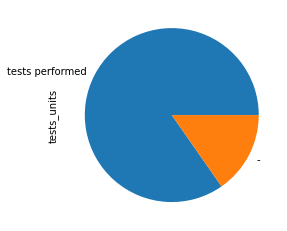

In [8]:
# Analyse de fond

# Variables qualitatives
for col in df.select_dtypes('object'):
	df[col] = df[col].fillna('-')
	pyplot.figure()
	df[col].value_counts().plot.pie()
	print(f'{col :-<30} {df[col].unique()}')

# Variables quantitatives
# for col in df.select_dtypes('float'):
# 	seaborn.displot(df[col])

In [9]:
# Création de relations target / variables

missing_rate = df.isna().sum() / df.shape[0]

# Groupe de mortalité et d'admissions à l'hopital
mortality_columns = df.columns[(missing_rate < 0.87) & (missing_rate > 0.85)]
# Groupe de vaccination
vaccination_columns = df.columns[(missing_rate < 0.53) & (missing_rate > 0.51)]
# Groupe de tests
tests_columns = df.columns[(missing_rate < 0.17) & (missing_rate > 0.15)]

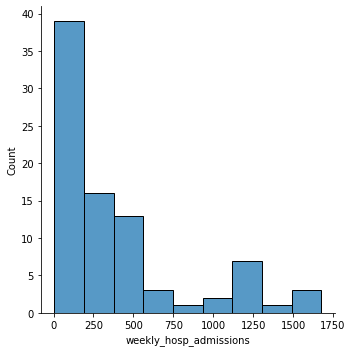

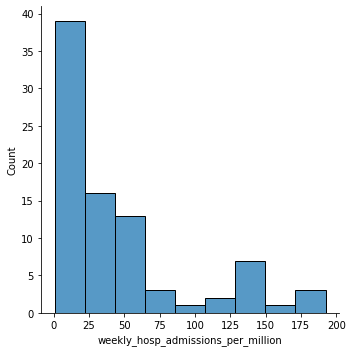

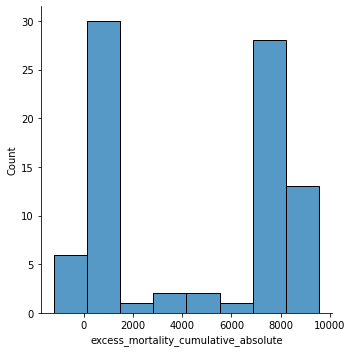

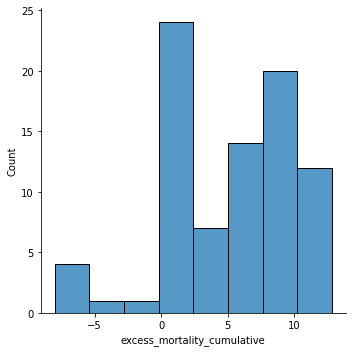

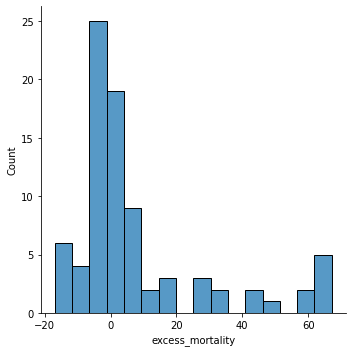

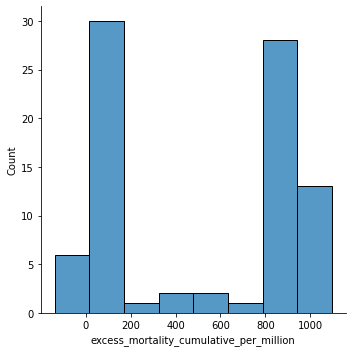

In [10]:
# Groupe de mortalié et d'admissions à l'hopital

for col in mortality_columns:
	seaborn.displot(df[col])

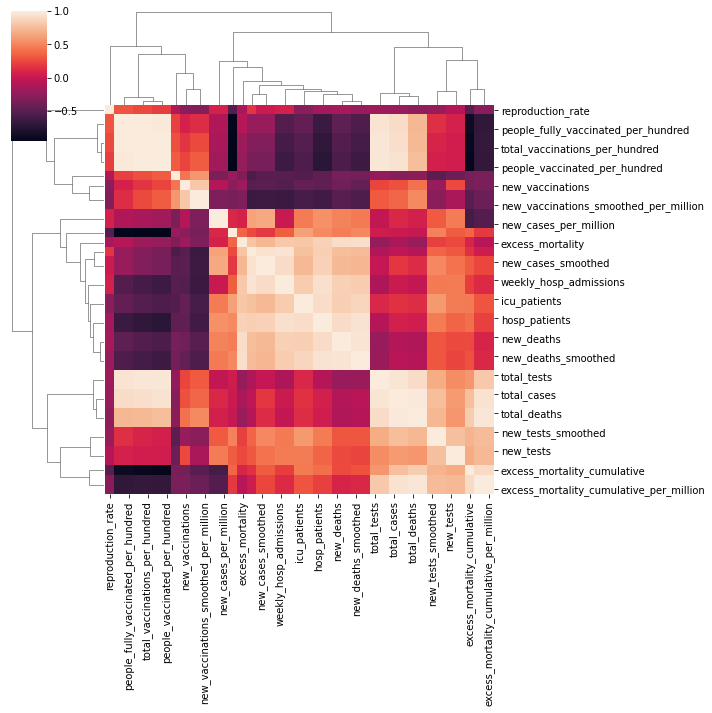

In [11]:
# Création de variables / variables

seaborn.clustermap(df.select_dtypes('float').corr())

# Certaines variables sont très corrélées: plus de 0.9 et forment des groupes à surveiller (paquets beiges)

In [12]:
dff = df.drop(['excess_mortality_cumulative', 'excess_mortality_cumulative_per_million', 'excess_mortality', 'excess_mortality_cumulative_absolute', 'weekly_hosp_admissions', 'weekly_hosp_admissions_per_million', 'tests_units'], axis=1)

dff = dff.dropna()
dff.tail()

,total_cases,new_cases,total_cases_per_million,new_cases_per_million,stringency_index,new_cases_smoothed,new_deaths_smoothed,new_cases_smoothed_per_million,new_deaths_smoothed_per_million,total_deaths,new_deaths,total_deaths_per_million,new_deaths_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,positive_rate,tests_per_case,new_tests_smoothed,new_tests_smoothed_per_thousand,total_vaccinations,people_vaccinated,total_vaccinations_per_hundred,people_vaccinated_per_hundred,new_vaccinations,new_vaccinations_smoothed,new_vaccinations_smoothed_per_million,people_fully_vaccinated,people_fully_vaccinated_per_hundred
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-10-09,848418.0,0.0,97345.945,0.000,46.3,977.857,3.857,112.198,0.443,11120.0,0.0,1275.889,0.000,0.86,150.0,17.211,403.0,46.239,32440.0,10763019.0,1234.929,3.722,0.033,30.3,32802.0,3.764,10663776.0,5606884.0,122.35,64.33,20361.0,23192.0,2661.0,5206441.0,59.74
2021-10-10,848418.0,0.0,97345.945,0.000,46.3,977.857,3.857,112.198,0.443,11120.0,0.0,1275.889,0.000,0.87,142.0,16.293,393.0,45.092,15593.0,10778612.0,1236.718,1.789,0.033,30.3,32877.0,3.772,10667022.0,5607812.0,122.39,64.34,3246.0,23170.0,2658.0,5208900.0,59.77
2021-10-11,850684.0,2266.0,97605.942,259.997,46.3,925.000,4.286,106.133,0.492,11133.0,13.0,1277.380,1.492,0.87,146.0,16.752,419.0,48.075,23534.0,10802146.0,1239.419,2.700,0.033,30.3,31856.0,3.655,10692186.0,5615026.0,122.68,64.43,25164.0,23213.0,2663.0,5228214.0,59.99
2021-10-12,851610.0,926.0,97712.189,106.248,46.3,910.857,4.714,104.510,0.541,11140.0,7.0,1278.183,0.803,0.87,136.0,15.604,406.0,46.584,24759.0,10826905.0,1242.259,2.841,0.034,29.4,30799.0,3.534,10717520.0,5622571.0,122.97,64.51,25334.0,23382.0,2683.0,5247524.0,60.21
2021-10-13,852658.0,1048.0,97832.435,120.246,46.3,904.429,3.000,103.772,0.344,11146.0,6.0,1278.872,0.688,0.87,135.0,15.490,396.0,45.436,21425.0,10848330.0,1244.718,2.458,0.034,29.4,29146.0,3.344,10750085.0,5631525.0,123.34,64.62,32565.0,23876.0,2739.0,5272961.0,60.50


In [37]:
dff.isnull().sum().any()

# aucune valeur null

False

<AxesSubplot:xlabel='date'>

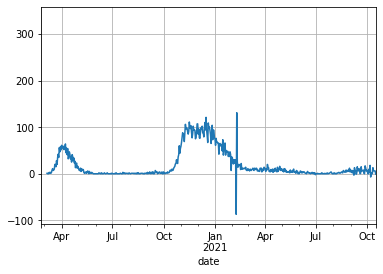

In [38]:
column_name = 'new_deaths'

chosen_df = df[column_name]
chosen_df.plot()
chosen_df.hist()

<AxesSubplot:xlabel='date'>

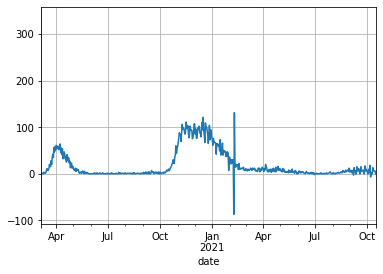

In [39]:
chosen_df = chosen_df.dropna()

chosen_df.plot()
chosen_df.hist()

In [40]:
X = chosen_df.index.values.reshape(-1, 1)
y = chosen_df.values.reshape(-1, 1)

In [41]:
from sklearn.preprocessing import StandardScaler
sc_y = StandardScaler()
y = sc_y.fit_transform(y)

# Normaliser

In [42]:
from sklearn.svm import SVR
from datetime import datetime
regressor = SVR(kernel='rbf')
regressor.fit(X, y)

y_pred = regressor.predict(X)

y_today = regressor.predict([[datetime.now().timestamp()]])
y_today = sc_y.inverse_transform(y_today)
print(f"Today {column_name}: {y_today[0]:.3f}")

Today new_deaths: 11.597


C:\Users\leon.muller\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


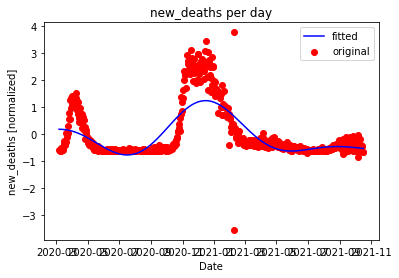

In [43]:
pyplot.scatter(X, y, color='red', label='original')
pyplot.plot(X, y_pred, color='blue', label='fitted')
pyplot.title(f"{column_name} per day")
pyplot.xlabel('Date')
pyplot.ylabel(f"{column_name} [normalized]")
pyplot.legend()
pyplot.show()

In [44]:
from sklearn.metrics import mean_squared_error

score = regressor.score(X, y)
print(f"R-squared: {score:.3f}")
print(f"MSE: {mean_squared_error(y, y_pred):.3f}", )

R-squared: 0.627
MSE: 0.373
